# Imports

In [1]:
! pip install ultralytics
! pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 10.9 MB/s eta 0:00:00


In [2]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset Splitting

In [3]:
train_imgs_dir="/kaggle/input/car-object-detection/data/training_images"
train_labels="/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"

test_imgs_dir="/kaggle/input/car-object-detection/data/testing_images"

In [4]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

# Custom Dataset to Yolo Format

The Ultralytics YOLO format is a dataset configuration format that allows you to define the dataset root directory, the relative paths to training/validation/testing image directories or *.txt files containing image paths, and a dictionary of class names.

In [5]:
#yolo dataset format 

# root directory
!mkdir "/kaggle/working/data"

# images directory 
!mkdir "/kaggle/working/data/images"

# train and test subdirectories with image directory
!mkdir "/kaggle/working/data/images/train"
!mkdir "/kaggle/working/data/images/val"

# labels directory
!mkdir "/kaggle/working/data/labels"

# train and test subdirectories with labels directory
!mkdir "/kaggle/working/data/labels/train"
!mkdir "/kaggle/working/data/labels/val"

In [6]:
root_dir="/kaggle/working/data"
labels_dir="/kaggle/working/data/labels"
images_dir="/kaggle/working/data/images"

In [7]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [8]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"
        
    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values
        
        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")
                
    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)

In [9]:
yolo_format=dict(path="/kaggle/working/data",
                 train="/kaggle/working/data/images/train",
                 val="/kaggle/working/data/images/val",
                 nc=1,
                 names={0:"car"})
             
with open('/kaggle/working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

# Wandb login

This is a required step for training, you can look at small tutorial for help
**[Weights & Biases Tutorial](https://www.kaggle.com/code/samuelcortinhas/weights-biases-tutorial-beginner)**

In [10]:
import wandb

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# my_secret = user_secrets.get_secret("wandb_api_key") 


from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Wandb")

wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Training

In [11]:
"""Device is determined automatically. If a GPU is available then it will be used, 
   otherwise training will start on CPU."""

model=YOLO('yolov8m.pt')
model.train(data="/kaggle/working/yolo.yaml",epochs=50,patience=5,batch=8,
                    lr0=0.0005,imgsz=640)

100%|██████████| 49.7M/49.7M [00:00<00:00, 55.8MB/s]
Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo.yaml, epochs=50, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e59d2ea2260>
fitness: 0.6865693281298785
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.65359])
names: {0: 'car'}
plot: False
results_dict: {'metrics/precision(B)': 0.9453125045091219, 'metrics/recall(B)': 0.957983193277311, 'metrics/mAP50(B)': 0.983387366182281, 'metrics/mAP50-95(B)': 0.653589546124056, 'fitness': 0.6865693281298785}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.1574665752809439, 'inference': 6.2827565776768015, 'loss': 0.0016297867049032183, 'postprocess': 1.118297007546496}

# Validate

In [12]:
path_best_weights="/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val() 

Ultralytics YOLOv8.0.170 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
val: Scanning /kaggle/working/data/labels/val.cache... 74 images, 127 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.60it/s]
                   all        201        119      0.938      0.958      0.983      0.652
Speed: 0.9ms preprocess, 7.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val


In [13]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.6522672200149977
Mean Average Precision @ .50   : 0.9833010844991288
Mean Average Precision @ .70   : 0.7887902228485631


# Prediction

In [14]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)


image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 71.0ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 11.0ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 11.0ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 11.0ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 11.0ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 11.0ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 11.1ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 11.0ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_

In [15]:
# directory for saving predictions on test dataset
!mkdir "/kaggle/working/predictions"

In [16]:
prediction_dir="/kaggle/working/predictions"

In [17]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

# Prediction Visualization

In [18]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

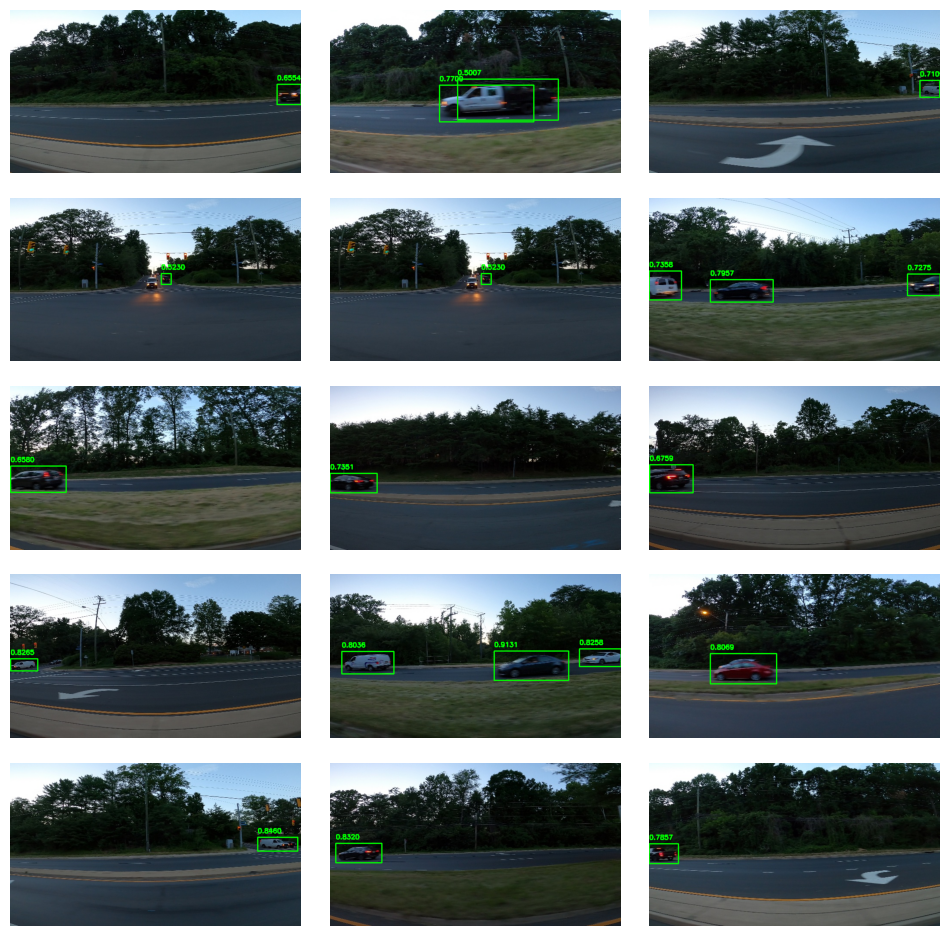

In [19]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    
plt.savefig("1.png")